In [1]:
# Extended analysis to include batch sizes 1, 2, 4, 8
# Focus (B): per-dataset RMSE changes across all batch sizes (per-dataset trend visualization)
# Preserves original plotting style and extends comparisons.

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'legend.fontsize': 14,
    #'axes.labelweight': 'bold',
    'legend.title_fontsize': 13,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.framealpha': 0.9,
    'font.size': 16,
    'axes.labelsize': 15,
    'axes.titlesize': 16,
    'figure.dpi': 100,
    'savefig.dpi': 300
})

print("="*90)
print("**BATCH SIZE COMPARISON: batch_size=1,2,4,8 (extended)**")
print("="*90)

**BATCH SIZE COMPARISON: batch_size=1,2,4,8 (extended)**


In [3]:
# ====================================================================
# DATASETS & SCENARIOS (keep same dataset order as in batchTABLE)
# ====================================================================
#print("="*90)
#print("**DATASETS & SCENARIOS (keep same dataset order as in batchTABLE)**")
#print("="*90)
datasets = ['Boston', 'BreastCancer', 'Credit',
            'Glass', 'Haberman', 'Iris', 'SlumpTest', 'Sonar']

# scenarios order used throughout this script:
# 'MCAR-Uniform', 'MCAR-Random', 'MNAR-Uniform', 'MNAR-Random'
scenarios = ['MCAR-Uniform', 'MCAR-Random', 'MNAR-Uniform', 'MNAR-Random']

In [4]:
# ====================================================================
# DATA: extracted from batchTABLE.txt
# Table column order in file: (Uniform MCAR), (Uniform MNAR), (Random MCAR), (Random MNAR)
# We map to our scenario order as: MCAR-Uniform = col1, MCAR-Random = col3, MNAR-Uniform = col2, MNAR-Random = col4
# ====================================================================
print("="*90)
print("**DATA: extracted from batchTABLE.txt**")
print("="*90)
# Batch size 1 (from table)
batch1 = {
    'MCAR-Uniform': [0.214, 0.131, 0.325, 0.146, 0.238, 0.269, 0.252, 0.187],
    'MCAR-Random' : [0.219, 0.287, 0.303, 0.165, 0.203, 0.255, 0.214, 0.184],
    'MNAR-Uniform': [0.151, 0.145, 0.311, 0.145, 0.193, 0.083, 0.142, 0.169],
    'MNAR-Random' : [0.153, 0.218, 0.301, 0.201, 0.159, 0.047, 0.188, 0.163]
}

# Batch size 2 (extracted)
batch2 = {
    'MCAR-Uniform': [0.207, 0.294, 0.319, 0.189, 0.247, 0.211, 0.280, 0.201],
    'MCAR-Random' : [0.264, 0.295, 0.165, 0.167, 0.197, 0.242, 0.287, 0.178],
    'MNAR-Uniform': [0.195, 0.164, 0.273, 0.109, 0.144, 0.094, 0.260, 0.164],
    'MNAR-Random' : [0.194, 0.247, 0.330, 0.120, 0.281, 0.190, 0.208, 0.115]
}

# Batch size 4 (extracted)
batch4 = {
    'MCAR-Uniform': [0.223, 0.269, 0.301, 0.189, 0.261, 0.287, 0.278, 0.192],
    'MCAR-Random' : [0.233, 0.229, 0.247, 0.123, 0.243, 0.417, 0.203, 0.192],
    'MNAR-Uniform': [0.203, 0.184, 0.294, 0.145, 0.111, 0.335, 0.193, 0.201],
    'MNAR-Random' : [0.192, 0.115, 0.231, 0.109, 0.181, 0.006, 0.194, 0.164]
}

# Batch size 8 (extracted; matches original batch8_data)
batch8 = {
    'MCAR-Uniform': [0.204, 0.257, 0.300, 0.146, 0.213, 0.313, 0.216, 0.190],
    'MCAR-Random' : [0.232, 0.280, 0.233, 0.188, 0.225, 0.192, 0.208, 0.210],
    'MNAR-Uniform': [0.211, 0.208, 0.219, 0.120, 0.262, 0.267, 0.165, 0.187],
    'MNAR-Random' : [0.192, 0.200, 0.216, 0.206, 0.254, 0.059, 0.175, 0.189]
}

# Aggregate batches into one structure for loops
batch_data = {
    1: batch1,
    2: batch2,
    4: batch4,
    8: batch8
}
batch_sizes = [1, 2, 4, 8]

print("Loaded RMSE data for batch sizes:", batch_sizes)

**DATA: extracted from batchTABLE.txt**
Loaded RMSE data for batch sizes: [1, 2, 4, 8]


In [5]:
# ====================================================================
# 1. OVERALL SUMMARY ACROSS BATCH SIZES (mean RMSE across datasets & scenarios)
# ====================================================================
print("\n1. AGGREGATED MEAN RMSE PER BATCH SIZE (across all datasets & scenarios)")
print("-" * 90)
summary_rows = []
for b in batch_sizes:
    all_rmse = np.concatenate([batch_data[b][s] for s in scenarios])
    summary_rows.append({
        'Batch': b,
        'Mean_RMSE': np.mean(all_rmse),
        'Std_RMSE': np.std(all_rmse, ddof=1)
    })

summary_df = pd.DataFrame(summary_rows).set_index('Batch')
print(summary_df.to_string())

# Pairwise Wilcoxon tests vs batch=1
print("\nPairwise Wilcoxon tests (paired across all scenario/dataset entries) vs B1:")
ref = np.concatenate([batch_data[1][s] for s in scenarios])
for b in batch_sizes:
    if b == 1: continue
    arr_b = np.concatenate([batch_data[b][s] for s in scenarios])
    try:
        w, p = wilcoxon(ref, arr_b)
    except Exception as e:
        w, p = 0.0, 1.0
    print(f"  B1 vs B{b}: W={w:.1f}, p={p:.6f}")

#


1. AGGREGATED MEAN RMSE PER BATCH SIZE (across all datasets & scenarios)
------------------------------------------------------------------------------------------
       Mean_RMSE  Std_RMSE
Batch                     
1       0.198781  0.065734
2       0.213469  0.063512
4       0.210781  0.076747
8       0.210531  0.049516

Pairwise Wilcoxon tests (paired across all scenario/dataset entries) vs B1:
  B1 vs B2: W=194.0, p=0.190521
  B1 vs B4: W=216.0, p=0.530591
  B1 vs B8: W=197.5, p=0.322299


In [6]:
# ============================================================================
# 1. OVERALL PERFORMANCE COMPARISON (Extended: Batch Sizes = 1, 2, 4, 8)
# ============================================================================
print("\n1. OVERALL RMSE COMPARISON ACROSS BATCH SIZES (1, 2, 4, 8)")
print("-" * 90)

comparison_summary = []
batch_sizes = [1, 2, 4, 8]

for scenario in scenarios:
    # Collect RMSE arrays for each batch size
    rmse_by_batch = {b: np.array(batch_data[b][scenario]) for b in batch_sizes}

    #rmse_by_batch = {b: np.array(batch_data[b][scenario]['RMSE']) for b in batch_sizes}

    # Compute mean & std per batch size
    stats = {b: {'mean': np.mean(rmse_by_batch[b]), 'std': np.std(rmse_by_batch[b], ddof=1)} for b in batch_sizes}

    # Reference batch = 1 for pairwise comparisons
    base = rmse_by_batch[1]
    pairwise_tests = {}
    for b in [2, 4, 8]:
        try:
            w_stat, w_pval = wilcoxon(base, rmse_by_batch[b])
        except Exception:
            w_stat, w_pval = 0, 1.0
        t_stat, t_pval = ttest_rel(base, rmse_by_batch[b])
        diff = base - rmse_by_batch[b]
        cohens_d = np.mean(diff) / np.std(diff, ddof=1)
        pairwise_tests[b] = {'wilcoxon_p': w_pval, 't_p': t_pval, 'cohen_d': cohens_d}

    comparison_summary.append({
        'Scenario': scenario,
        'Mean_B1': stats[1]['mean'], 'Std_B1': stats[1]['std'],
        'Mean_B2': stats[2]['mean'], 'Std_B2': stats[2]['std'],
        'Mean_B4': stats[4]['mean'], 'Std_B4': stats[4]['std'],
        'Mean_B8': stats[8]['mean'], 'Std_B8': stats[8]['std'],
        'Δ(1→2)': stats[2]['mean'] - stats[1]['mean'],
        'Δ(1→4)': stats[4]['mean'] - stats[1]['mean'],
        'Δ(1→8)': stats[8]['mean'] - stats[1]['mean'],
        'Wilcoxon_p(1→2)': pairwise_tests[2]['wilcoxon_p'],
        'Wilcoxon_p(1→4)': pairwise_tests[4]['wilcoxon_p'],
        'Wilcoxon_p(1→8)': pairwise_tests[8]['wilcoxon_p'],
        'Cohen_d(1→8)': pairwise_tests[8]['cohen_d']
    })

comp_df = pd.DataFrame(comparison_summary)
print("\nScenario-wise Comparison (Mean RMSE ± Std):")
print(comp_df[['Scenario','Mean_B1','Mean_B2','Mean_B4','Mean_B8']].to_string(index=False, float_format="%.3f"))

print("\nΔ (Mean RMSE Difference) and Wilcoxon p-values vs B1:")
for _, row in comp_df.iterrows():
    print(f"{row['Scenario']:15s}: "
          f"Δ(1→2)={row['Δ(1→2)']:+.3f}, "
          f"Δ(1→4)={row['Δ(1→4)']:+.3f}, "
          f"Δ(1→8)={row['Δ(1→8)']:+.3f} | "
          f"p(1→8)={row['Wilcoxon_p(1→8)']:.4f} "
          f"d(1→8)={row['Cohen_d(1→8)']:+.2f}")

# -------------------------------------------------------------------------
# Aggregated across all scenarios
# -------------------------------------------------------------------------
print("\n\nAGGREGATED ACROSS ALL SCENARIOS:")
agg_summary = []
for b in batch_sizes:
    all_rmse = np.concatenate([batch_data[b][s] for s in scenarios])
    agg_summary.append({'Batch': b, 'Mean': np.mean(all_rmse), 'Std': np.std(all_rmse, ddof=1)})

agg_df = pd.DataFrame(agg_summary)
print(agg_df.to_string(index=False, float_format="%.4f"))

# Wilcoxon vs batch=1
ref_all = np.concatenate([batch_data[1][s] for s in scenarios])
for b in [2, 4, 8]:
    test_all = np.concatenate([batch_data[b][s] for s in scenarios])
    try:
        w_all, p_all = wilcoxon(ref_all, test_all)
    except Exception:
        w_all, p_all = 0, 1.0
    diff = np.mean(test_all) - np.mean(ref_all)
    pct = diff / np.mean(ref_all) * 100
    print(f"  B1 vs B{b}: Δ={diff:+.4f} ({pct:+.1f}%), p={p_all:.6f}")



1. OVERALL RMSE COMPARISON ACROSS BATCH SIZES (1, 2, 4, 8)
------------------------------------------------------------------------------------------

Scenario-wise Comparison (Mean RMSE ± Std):
    Scenario  Mean_B1  Mean_B2  Mean_B4  Mean_B8
MCAR-Uniform    0.220    0.243    0.250    0.230
 MCAR-Random    0.229    0.224    0.236    0.221
MNAR-Uniform    0.167    0.175    0.208    0.205
 MNAR-Random    0.179    0.211    0.149    0.186

Δ (Mean RMSE Difference) and Wilcoxon p-values vs B1:
MCAR-Uniform   : Δ(1→2)=+0.023, Δ(1→4)=+0.030, Δ(1→8)=+0.010 | p(1→8)=1.0000 d(1→8)=-0.18
MCAR-Random    : Δ(1→2)=-0.004, Δ(1→4)=+0.007, Δ(1→8)=-0.008 | p(1→8)=1.0000 d(1→8)=+0.20
MNAR-Uniform   : Δ(1→2)=+0.008, Δ(1→4)=+0.041, Δ(1→8)=+0.038 | p(1→8)=0.3125 d(1→8)=-0.47
MNAR-Random    : Δ(1→2)=+0.032, Δ(1→4)=-0.030, Δ(1→8)=+0.008 | p(1→8)=0.6406 d(1→8)=-0.15


AGGREGATED ACROSS ALL SCENARIOS:
 Batch   Mean    Std
     1 0.1988 0.0657
     2 0.2135 0.0635
     4 0.2108 0.0767
     8 0.2105 0.0495
  B1

In [7]:
# ============================================================================
# 2. SIGNIFICANCE ASSESSMENT
# ============================================================================
print("\n\n2. STATISTICAL SIGNIFICANCE (α=0.05)")
print("-" * 90)

# Now comp_df has columns for Wilcoxon_p(1→2), (1→4), (1→8)
for _, row in comp_df.iterrows():
    for target in [2, 4, 8]:
        pval = row[f'Wilcoxon_p(1→{target})']
        sig = (
            "***" if pval < 0.001 else
            "**" if pval < 0.01 else
            "*" if pval < 0.05 else
            "n.s."
        )

        mean1 = row['Mean_B1']
        meant = row[f'Mean_B{target}']
        winner = f"B1 BETTER" if mean1 < meant else f"B{target} BETTER"
        diff = meant - mean1
        pct_change = (diff / mean1) * 100

        cohens_d = row['Cohen_d(1→8)'] if target == 8 else np.nan  # Only available for 1→8 in comp_df

        print(f"{row['Scenario']:15s} (1→{target}): "
              f"p={pval:.4f} {sig:4s} | {winner:16s} | "
              f"Δ={diff:+.3f} ({pct_change:+.1f}%) | "
              f"d={cohens_d if not np.isnan(cohens_d) else 0:+.2f}")

#################################################################



2. STATISTICAL SIGNIFICANCE (α=0.05)
------------------------------------------------------------------------------------------
MCAR-Uniform    (1→2): p=0.3125 n.s. | B1 BETTER        | Δ=+0.023 (+10.6%) | d=+0.00
MCAR-Uniform    (1→4): p=0.0781 n.s. | B1 BETTER        | Δ=+0.030 (+13.5%) | d=+0.00
MCAR-Uniform    (1→8): p=1.0000 n.s. | B1 BETTER        | Δ=+0.010 (+4.4%) | d=-0.18
MCAR-Random     (1→2): p=1.0000 n.s. | B2 BETTER        | Δ=-0.004 (-1.9%) | d=+0.00
MCAR-Random     (1→4): p=0.8438 n.s. | B1 BETTER        | Δ=+0.007 (+3.1%) | d=+0.00
MCAR-Random     (1→8): p=1.0000 n.s. | B8 BETTER        | Δ=-0.008 (-3.4%) | d=+0.20
MNAR-Uniform    (1→2): p=0.9453 n.s. | B1 BETTER        | Δ=+0.008 (+4.8%) | d=+0.00
MNAR-Uniform    (1→4): p=0.2969 n.s. | B1 BETTER        | Δ=+0.041 (+24.4%) | d=+0.00
MNAR-Uniform    (1→8): p=0.3125 n.s. | B1 BETTER        | Δ=+0.038 (+22.4%) | d=-0.47
MNAR-Random     (1→2): p=0.3828 n.s. | B1 BETTER        | Δ=+0.032 (+17.8%) | d=+0.00
MNAR-Random    

In [8]:
# ============================================================================
# 3. DATASET-SPECIFIC ANALYSIS
# ============================================================================
print("\n\n3. DATASET-SPECIFIC PERFORMANCE")
print("-" * 90)

dataset_analysis = []
batch_sizes = [1, 2, 4, 8]

for dataset_idx, dataset_name in enumerate(datasets):
    row_data = {'Dataset': dataset_name}
    batch_wins = {b: 0 for b in batch_sizes}

    # Gather all values per scenario
    for scenario in scenarios:
        for b in batch_sizes:
            row_data[f'{scenario}_B{b}'] = batch_data[b][scenario][dataset_idx]

        # Determine which batch performed best (lowest RMSE)
        scenario_vals = {b: batch_data[b][scenario][dataset_idx] for b in batch_sizes}
        best_b = min(scenario_vals, key=scenario_vals.get)
        batch_wins[best_b] += 1

        # Store deltas relative to batch=1
        for b in [2, 4, 8]:
            row_data[f'{scenario}_Δ(1→{b})'] = scenario_vals[b] - scenario_vals[1]

    # Add total win counts
    for b in batch_sizes:
        row_data[f'B{b}_Total_Wins'] = batch_wins[b]

    dataset_analysis.append(row_data)

dataset_df = pd.DataFrame(dataset_analysis)

print("\nDataset Performance Summary (Best Batch per Scenario Count):")
print("-" * 90)
for dataset in datasets:
    data = dataset_df[dataset_df['Dataset'] == dataset].iloc[0]
    summary_line = f"{dataset:20s}: " + ", ".join([f"B{b} wins {int(data[f'B{b}_Total_Wins'])}/4" for b in batch_sizes])
    best_overall = max(batch_sizes, key=lambda b: data[f'B{b}_Total_Wins'])
    print(summary_line + f" → Overall Best: B{best_overall}")

    # Show detailed per-scenario performance
    for scenario in scenarios:
        values = [data[f'{scenario}_B{b}'] for b in batch_sizes]
        diffs = [data[f'{scenario}_Δ(1→{b})'] for b in [2, 4, 8]]
        print(f"  {scenario:15s}: " + " | ".join([f"B{b}={v:.3f}" for b, v in zip(batch_sizes, values)]) +
              f"  → Δ(1→2)={diffs[0]:+.3f}, Δ(1→4)={diffs[1]:+.3f}, Δ(1→8)={diffs[2]:+.3f}")






3. DATASET-SPECIFIC PERFORMANCE
------------------------------------------------------------------------------------------

Dataset Performance Summary (Best Batch per Scenario Count):
------------------------------------------------------------------------------------------
Boston              : B1 wins 3/4, B2 wins 0/4, B4 wins 0/4, B8 wins 1/4 → Overall Best: B1
  MCAR-Uniform   : B1=0.214 | B2=0.207 | B4=0.223 | B8=0.204  → Δ(1→2)=-0.007, Δ(1→4)=+0.009, Δ(1→8)=-0.010
  MCAR-Random    : B1=0.219 | B2=0.264 | B4=0.233 | B8=0.232  → Δ(1→2)=+0.045, Δ(1→4)=+0.014, Δ(1→8)=+0.013
  MNAR-Uniform   : B1=0.151 | B2=0.195 | B4=0.203 | B8=0.211  → Δ(1→2)=+0.044, Δ(1→4)=+0.052, Δ(1→8)=+0.060
  MNAR-Random    : B1=0.153 | B2=0.194 | B4=0.192 | B8=0.192  → Δ(1→2)=+0.041, Δ(1→4)=+0.039, Δ(1→8)=+0.039
BreastCancer        : B1 wins 2/4, B2 wins 0/4, B4 wins 2/4, B8 wins 0/4 → Overall Best: B1
  MCAR-Uniform   : B1=0.131 | B2=0.294 | B4=0.269 | B8=0.257  → Δ(1→2)=+0.163, Δ(1→4)=+0.138, Δ(1→8)=+0.12

In [9]:
# ============================================================================
# 4. WIN/LOSS SUMMARY (Extended for Batch Sizes = 1, 2, 4, 8)
# ============================================================================
print("\n\n4. OVERALL WIN/LOSS SUMMARY (lowest RMSE wins)")
print("-" * 90)

batch_sizes = [1, 2, 4, 8]
win_counts = {b: 0 for b in batch_sizes}
tie_counts = 0

# Iterate over all datasets × scenarios
for scenario in scenarios:
    for i, ds in enumerate(datasets):
        # Collect RMSEs for each batch for this dataset-scenario pair
        values = {b: batch_data[b][scenario][i] for b in batch_sizes}
        min_val = min(values.values())
        # Find all batches tied for min RMSE (within exact equality tolerance)
        winners = [b for b, v in values.items() if np.isclose(v, min_val, atol=1e-8)]
        if len(winners) > 1:
            tie_counts += 1
        for b in winners:
            win_counts[b] += 1

total_comparisons = len(datasets) * len(scenarios)
print(f"Total comparisons: {total_comparisons}")

# Overall win percentages
for b in batch_sizes:
    print(f"B{b} wins: {win_counts[b]:3d}/{total_comparisons} "
          f"({win_counts[b]/total_comparisons*100:5.1f}%)")

print(f"Ties (multiple equal minima): {tie_counts}/{total_comparisons} "
      f"({tie_counts/total_comparisons*100:.1f}%)")

# -------------------------------------------------------------------------
# Per-scenario breakdown
# -------------------------------------------------------------------------
print("\nPer-scenario breakdown (number of dataset wins per batch):")
for scenario in scenarios:
    scenario_wins = {b: 0 for b in batch_sizes}
    for i, ds in enumerate(datasets):
        values = {b: batch_data[b][scenario][i] for b in batch_sizes}
        min_val = min(values.values())
        winners = [b for b, v in values.items() if np.isclose(v, min_val, atol=1e-8)]
        for b in winners:
            scenario_wins[b] += 1
    total_pairs = len(datasets)
    formatted = ", ".join([f"B{b} {scenario_wins[b]}/{total_pairs} "
                           f"({scenario_wins[b]/total_pairs*100:4.1f}%)"
                           for b in batch_sizes])
    print(f"  {scenario:15s}: {formatted}")




4. OVERALL WIN/LOSS SUMMARY (lowest RMSE wins)
------------------------------------------------------------------------------------------
Total comparisons: 32
B1 wins:  10/32 ( 31.2%)
B2 wins:   7/32 ( 21.9%)
B4 wins:   7/32 ( 21.9%)
B8 wins:   9/32 ( 28.1%)
Ties (multiple equal minima): 1/32 (3.1%)

Per-scenario breakdown (number of dataset wins per batch):
  MCAR-Uniform   : B1 3/8 (37.5%), B2 1/8 (12.5%), B4 0/8 ( 0.0%), B8 5/8 (62.5%)
  MCAR-Random    : B1 1/8 (12.5%), B2 3/8 (37.5%), B4 3/8 (37.5%), B8 1/8 (12.5%)
  MNAR-Uniform   : B1 4/8 (50.0%), B2 2/8 (25.0%), B4 1/8 (12.5%), B8 1/8 (12.5%)
  MNAR-Random    : B1 2/8 (25.0%), B2 1/8 (12.5%), B4 3/8 (37.5%), B8 2/8 (25.0%)



 SUPPLEMENTARY: Mean RMSE by Scenario for each Batch (bar plot)
------------------------------------------------------------------------------------------


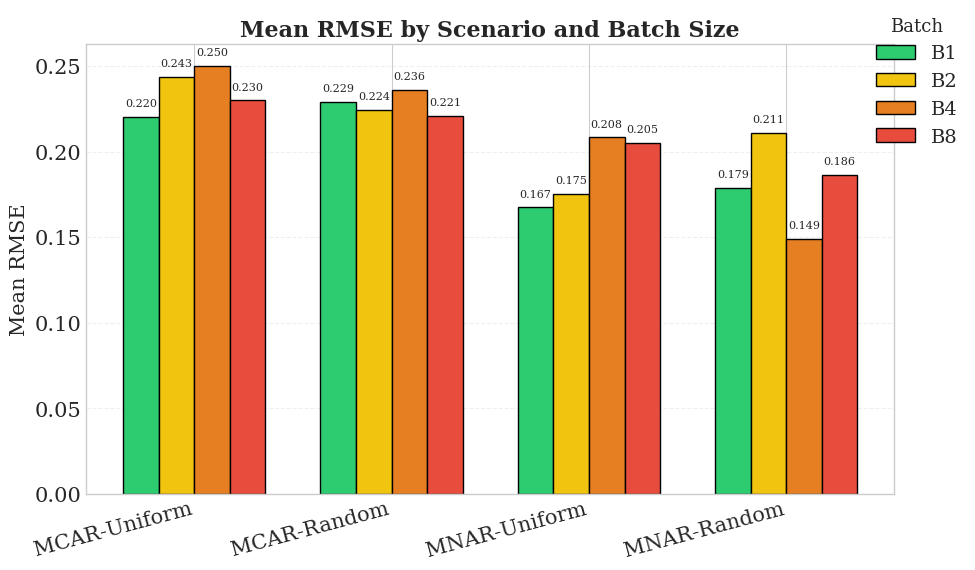

✓ Saved: batch_size_means_by_scenario.png/pdf


In [10]:
# ====================================================================
# SUPPLEMENTARY: Mean RMSE by Scenario for each Batch (small multiples)
# ====================================================================
print("\n SUPPLEMENTARY: Mean RMSE by Scenario for each Batch (bar plot)")
print("-" * 90)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(scenarios))
width = 0.18
cols = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']  # colors for batches 1,2,4,8

for i, b in enumerate(batch_sizes):
    means = [np.mean(batch_data[b][s]) for s in scenarios]
    ax.bar(x + (i - 1.5) * width, means, width, label=f'B{b}', color=cols[i], edgecolor='black')

for i, (s1, s2) in enumerate(zip(scenarios, scenarios)):
    # add numeric labels
    for j, b in enumerate(batch_sizes):
        val = np.mean(batch_data[b][s1])
        ax.text(i + (j - 1.5) * width, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=15, ha='right')
ax.set_ylabel('Mean RMSE')
ax.set_title('Mean RMSE by Scenario and Batch Size', fontweight='bold')
ax.legend(title='Batch', loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_path = "/content/drive/MyDrive/MIDA-our/Results/figures/"
plt.savefig(save_path + 'batch_size_means_by_scenario.png', dpi=300, bbox_inches='tight')
plt.savefig(save_path + 'batch_size_means_by_scenario.pdf', bbox_inches='tight')
plt.show()
print("✓ Saved: batch_size_means_by_scenario.png/pdf")

In [11]:
# ====================================================================
#  SAVE SUMMARY CSVs (optional) - save numeric tables for downstream use
# ====================================================================
print("\n SAVING summary CSVs to drive (RMSE per batch/scenario/dataset)")
print("-" * 90)
# Build a tidy DataFrame
rows = []
for b in batch_sizes:
    for s in scenarios:
        for i, ds in enumerate(datasets):
            rows.append({'Batch': b, 'Scenario': s, 'Dataset': ds, 'RMSE': batch_data[b][s][i]})
df_tidy = pd.DataFrame(rows)
csv_save_path = "/content/drive/MyDrive/MIDA-our/Results/figures/"
try:
    df_tidy.to_csv(csv_save_path + 'rmse_per_batch_scenario_dataset.csv', index=False)
    print("✓ Saved:", csv_save_path + 'rmse_per_batch_scenario_dataset.csv')
except Exception as e:
    print("! Warning: could not write CSV to drive. Exception:", e)




 SAVING summary CSVs to drive (RMSE per batch/scenario/dataset)
------------------------------------------------------------------------------------------
✓ Saved: /content/drive/MyDrive/MIDA-our/Results/figures/rmse_per_batch_scenario_dataset.csv


✓ Saved: figure_c_performance_trajectories.png/pdf


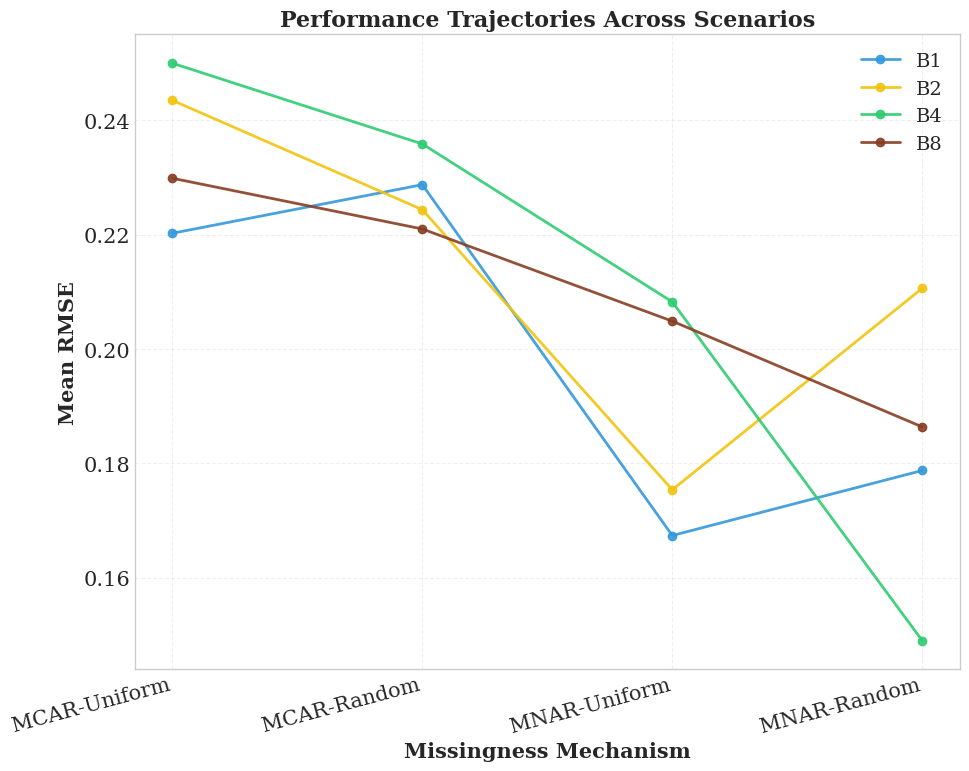

In [12]:
# ============================================================================
# PERFORMANCE TRAJECTORIES ACROSS SCENARIOS (Standalone)
# ============================================================================
fig_c, ax_c = plt.subplots(figsize=(10, 8))

# Define colors for each batch size (reuse existing palette)
colors = {
    1: "#3498db",   # blue
    2: "#f1c40f",   # yellow
    4: "#2ecc71",   # green
    8: "#873e23"    # burnt umber
}

x_scen = np.arange(len(scenarios))

# Plot mean RMSE per scenario for each batch size
for b in [1, 2, 4, 8]:
    y_vals = [np.mean(batch_data[b][s]) for s in scenarios]
    ax_c.plot(x_scen, y_vals, marker='o', linestyle='-',
              linewidth=2, markersize=6, color=colors[b],
              label=f"B{b}", alpha=0.9)

# Axis & grid styling
ax_c.set_xlabel("Missingness Mechanism", fontweight='bold')
ax_c.set_ylabel("Mean RMSE", fontweight='bold')
ax_c.set_title("Performance Trajectories Across Scenarios", fontweight='bold')
ax_c.set_xticks(x_scen)
ax_c.set_xticklabels(scenarios, rotation=15, ha='right')
ax_c.legend(loc='upper right', framealpha=0.9) #, title="Batch Size")
ax_c.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
save_path = "/content/drive/MyDrive/MIDA-our/Results/figures/"
plt.savefig(save_path + "figure_c_performance_trajectories.png",
            dpi=300, bbox_inches='tight')
plt.savefig(save_path + "figure_c_performance_trajectories.pdf",
            bbox_inches='tight')
print("✓ Saved: figure_c_performance_trajectories.png/pdf")
plt.show()


✓ Saved: batch_size_trajectories_extended.png/pdf


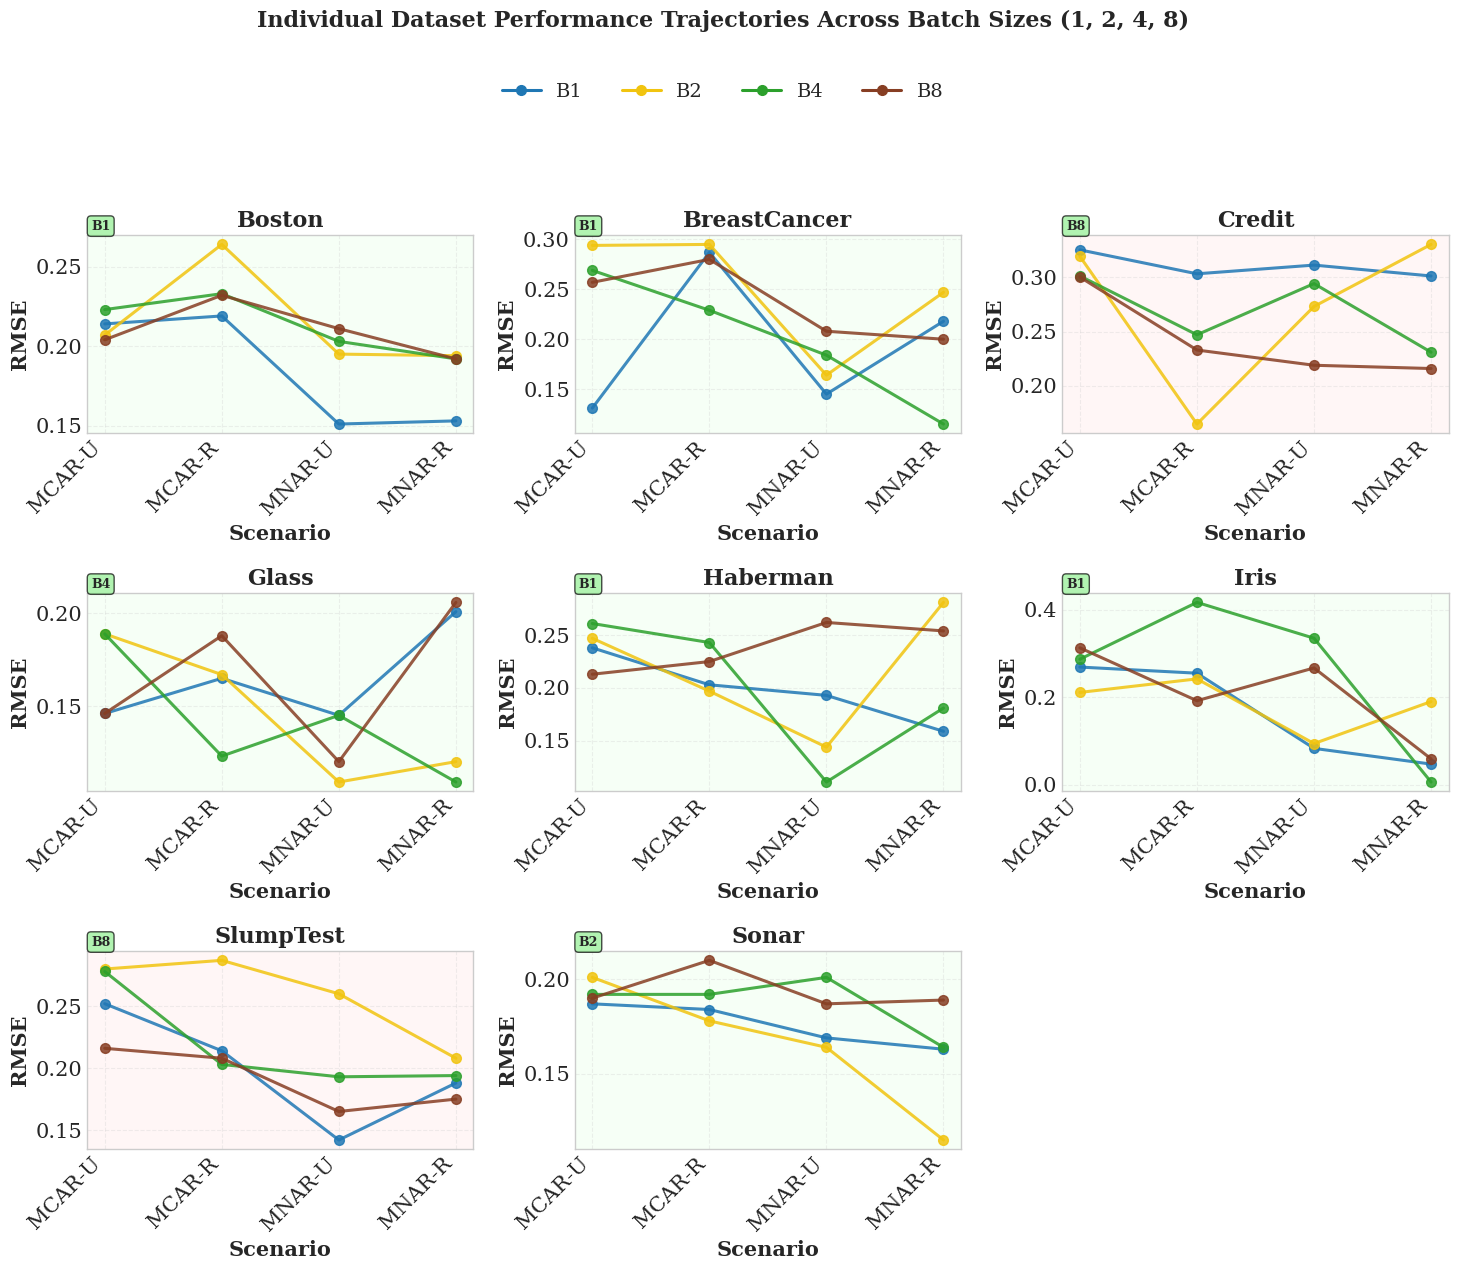

In [13]:
# ============================================================================
# CONNECTED LINE PLOTS (TRAJECTORY VISUALIZATION, EXTENDED: B=1,2,4,8)
# ============================================================================
fig3, axes = plt.subplots(3, 3, figsize=(15, 13))
fig3.suptitle('Individual Dataset Performance Trajectories Across Batch Sizes (1, 2, 4, 8)',
              fontsize=16, fontweight='bold')

# Remove the extra (9th) subplot so only 8 remain
fig3.delaxes(axes.flat[-1])


# Define colors for batches
colors = {
    'Batch=1': '#1f77b4',  # blue
    'Batch=2': '#f1c40f',  # yellow
    'Batch=4': '#2ca02c',  # green
    'Batch=8': '#873e23'   # red
}

batch_sizes = [1, 2, 4, 8]
batch_dict = {1: batch1, 2: batch2, 4: batch4, 8: batch8}

for idx, (dataset_name, ax) in enumerate(zip(datasets, axes.flat)):
    x_pos = np.arange(len(scenarios))

    # Plot lines for each batch
    for b in batch_sizes:
        y_vals = [batch_dict[b][s][idx] for s in scenarios]
        ax.plot(x_pos, y_vals,
                marker='o', linestyle='-', linewidth=2.2, markersize=7,
                color=colors[f'Batch={b}'], label=f'Batch={b}', alpha=0.85)

        # Annotate each point
        #for xi, yi in zip(x_pos, y_vals):
        #    ax.text(xi, yi + 0.005, f'{yi:.3f}', ha='center', va='bottom', fontsize=8)

    # Shade region for best-performing (lowest mean RMSE) batch
    mean_rmses = {b: np.mean([batch_dict[b][s][idx] for s in scenarios]) for b in batch_sizes}
    best_b = min(mean_rmses, key=mean_rmses.get)
    ax.set_facecolor('#f6fff6' if best_b in [1, 2, 4] else '#fff6f6')

    ax.set_xlabel('Scenario', fontweight='bold')
    ax.set_ylabel('RMSE', fontweight='bold')
    ax.set_title(f'{dataset_name}', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['MCAR-U', 'MCAR-R', 'MNAR-U', 'MNAR-R'],
                       rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--')

    # Add summary text: which batch had the lowest mean RMSE
    ax.text(0.01, 1.08, f'B{best_b}',
            transform=ax.transAxes, fontsize=9, fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Shared legend (centered under title)
handles = [plt.Line2D([0], [0], color=colors[f'Batch={b}'], marker='o', label=f'B{b}',
                      linewidth=2.2, markersize=7) for b in batch_sizes]
fig3.legend(handles=handles, loc='upper center', ncol=4, framealpha=0.9,
           bbox_to_anchor=(0.5, 0.93), borderaxespad=0.)
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout(rect=[0, 0, 1, 0.88])
save_path = "/content/drive/MyDrive/MIDA-our/Results/figures/"
plt.savefig(save_path + 'batch_size_trajectories_extended.png', dpi=300, bbox_inches='tight')
plt.savefig(save_path + 'batch_size_trajectories_extended.pdf', bbox_inches='tight')
print("✓ Saved: batch_size_trajectories_extended.png/pdf")
plt.show()

✓ Saved: batch_size_boxplots_extended.png/pdf


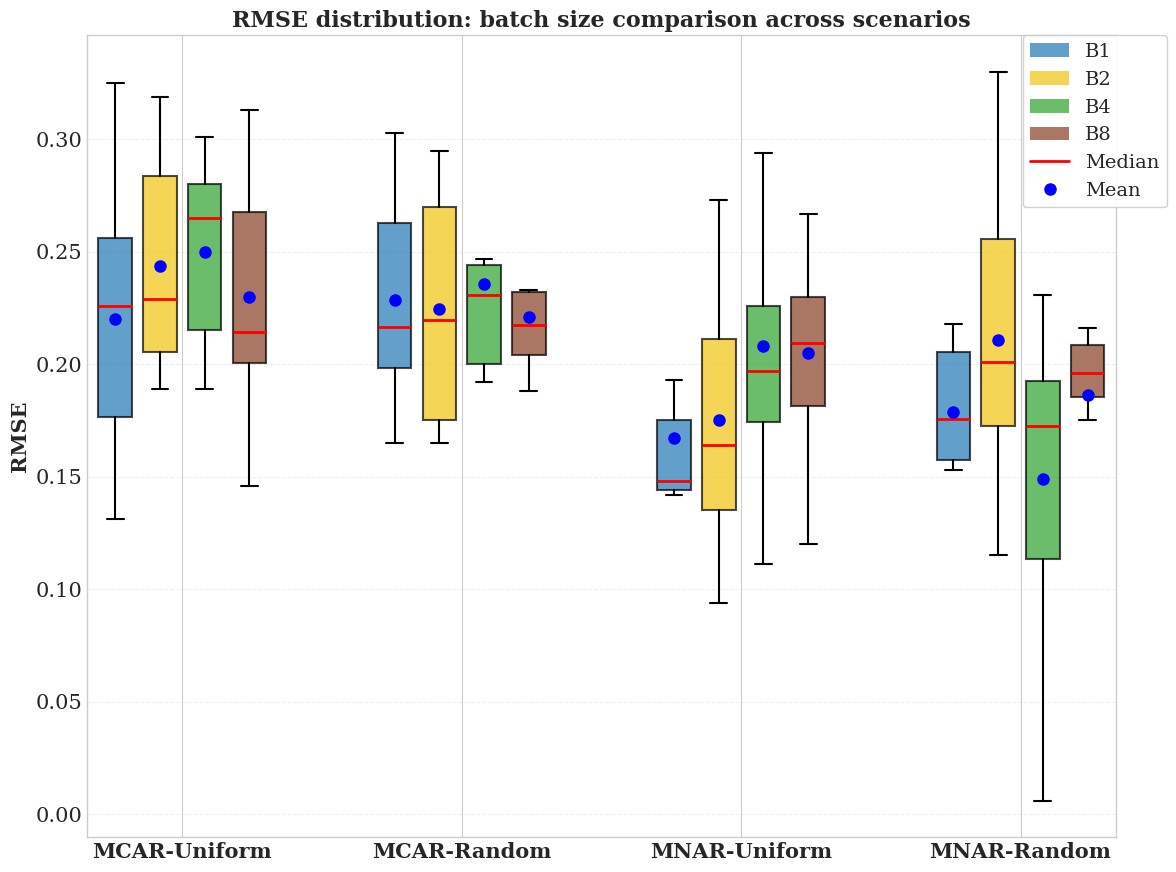

In [14]:
# ============================================================================
# BOX PLOT COMPARISON (Extended: Batch Sizes = 1, 2, 4, 8)
# ============================================================================
fig5, ax = plt.subplots(figsize=(12, 9))

# Prepare data for box plot (4 batch sizes × 4 scenarios)
batch_sizes = [1, 2, 4, 8]
batch_labels = [f'B={b}' for b in batch_sizes]

# Color mapping (extend your existing colors dictionary)
colors_boxmap = {
    1: colors['Batch=1'],
    2: colors['Batch=2'] if 'Batch=2' in colors else '#f1c40f',
    4: colors['Batch=4'] if 'Batch=4' in colors else '#e67e22',
    8: colors['Batch=8'] if 'Batch=8' in colors else '#e74c3c'
}

data_for_box = []
positions = []
colors_box = []
labels = []

# create grouped positions for boxplots: spacing = 5 units per scenario
group_spacing = 5
box_spacing = 0.8

for i, scenario in enumerate(scenarios):
    # add one box for each batch size within this scenario
    for j, b in enumerate(batch_sizes):
        data_for_box.append(batch_data[b][scenario])
        positions.append(i * group_spacing + j * box_spacing)
        colors_box.append(colors_boxmap[b])
        labels.append(f'{scenario}\nB={b}')

bp = ax.boxplot(
    data_for_box,
    positions=positions,
    widths=0.6,
    patch_artist=True,
    showmeans=True, # Ensure means are shown
    showfliers=False,     # ← REMOVE OUTLIERS (fixes the small empty dots)
    boxprops=dict(linewidth=1.5),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
    medianprops={
        'color': 'red',
        'linewidth': 2
    },
    meanprops={
        'marker':'o',
        'markerfacecolor':'blue',
        'markeredgecolor':'blue',
        'markersize':'8'
    }
)

# Color each box
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Aesthetics
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('RMSE distribution: batch size comparison across scenarios',
             fontweight='bold')
# scenario tick centers
xtick_positions = [i * group_spacing + (len(batch_sizes)-1) * box_spacing / 2 for i in range(len(scenarios))]
ax.set_xticks(xtick_positions)
ax.set_xticklabels(scenarios, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Box color legend
legend_elements = [Patch(facecolor=colors_boxmap[b], label=f'B{b}', alpha=0.7)
                   for b in batch_sizes]

# Custom mean/median legend items
median_line = Line2D([], [], color='red', lw=2, label='Median')
mean_marker = Line2D([], [], marker='o', markersize=8,
                     markerfacecolor='blue', markeredgecolor='blue',
                     linestyle='None', label='Mean')

# Combine everything
legend_elements.extend([median_line, mean_marker])

ax.legend(handles=legend_elements, loc='upper right',  bbox_to_anchor=(1.05, 1),
          borderaxespad=0,
          frameon=True
)


plt.tight_layout()
save_path = "/content/drive/MyDrive/MIDA-our/Results/figures/"
plt.savefig(save_path + 'batch_size_boxplots_extended.png', dpi=300, bbox_inches='tight')
plt.savefig(save_path + 'batch_size_boxplots_extended.pdf', bbox_inches='tight')
print("✓ Saved: batch_size_boxplots_extended.png/pdf")
plt.show()

In [15]:
# ============================================================================
# FRIEDMAN TEST: Across Batch Sizes (1, 2, 4, 8)
# ============================================================================
from scipy.stats import friedmanchisquare

print("\nFRIEDMAN TEST: RMSE differences across batch sizes (1, 2, 4, 8)")
print("-" * 90)

batch_sizes = [1, 2, 4, 8]
friedman_results = []

for scenario in scenarios:
    # Each dataset’s RMSE for each batch size
    rmse_values = [batch_data[b][scenario] for b in batch_sizes]

    # Check all have same length
    n = len(rmse_values[0])
    if not all(len(x) == n for x in rmse_values):
        print(f"⚠️ Skipping {scenario}: unequal sample lengths")
        continue

    # Run Friedman test
    stat, p = friedmanchisquare(*rmse_values)

    friedman_results.append({
        'Scenario': scenario,
        'Chi²': stat,
        'p-value': p
    })

# Print results
friedman_df = pd.DataFrame(friedman_results)
print(friedman_df.to_string(index=False, float_format="%.6f"))

# Interpretation
alpha = 0.05
print("\nInterpretation (α = 0.05):")
for _, row in friedman_df.iterrows():
    if row['p-value'] < alpha:
        print(f"  ✅ {row['Scenario']}: Significant differences (p = {row['p-value']:.6f})")
    else:
        print(f"  ❌ {row['Scenario']}: No significant difference (p = {row['p-value']:.6f})")

# ---------------------------------------------------------------------------
# Aggregate Friedman test across all scenarios (pooled dataset-level samples)
# ---------------------------------------------------------------------------
print("\nAGGREGATED FRIEDMAN TEST (all scenarios combined)")
print("-" * 90)
rmse_all_batches = [np.concatenate([batch_data[b][s] for s in scenarios]) for b in batch_sizes]
stat_all, p_all = friedmanchisquare(*rmse_all_batches)
print(f"  χ² = {stat_all:.4f}, p = {p_all:.6f}")
if p_all < alpha:
    print("  ✅ Significant difference between batch sizes overall")
else:
    print("  ❌ No significant difference between batch sizes overall")



FRIEDMAN TEST: RMSE differences across batch sizes (1, 2, 4, 8)
------------------------------------------------------------------------------------------
    Scenario     Chi²  p-value
MCAR-Uniform 8.076923 0.044448
 MCAR-Random 0.000000 1.000000
MNAR-Uniform 4.367089 0.224457
 MNAR-Random 5.962025 0.113472

Interpretation (α = 0.05):
  ✅ MCAR-Uniform: Significant differences (p = 0.044448)
  ❌ MCAR-Random: No significant difference (p = 1.000000)
  ❌ MNAR-Uniform: No significant difference (p = 0.224457)
  ❌ MNAR-Random: No significant difference (p = 0.113472)

AGGREGATED FRIEDMAN TEST (all scenarios combined)
------------------------------------------------------------------------------------------
  χ² = 3.7120, p = 0.294286
  ❌ No significant difference between batch sizes overall
